In [53]:
import pandas as pd
import numpy as np
import os
from datetime import datetime,date,timedelta
import json

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.exceptions import NotFound
from google.api_core.exceptions import BadRequest

In [54]:
start_date='2023-05-26'
date_col='prediction_date'
AssetName='SPY'


In [55]:
json_credential_file=r'C:\Windows\pongthorn-5decdc5124f5.json'
projectId='pongthorn'
dataset_id='FinAssetForecast'
table_id = f"{projectId}.{dataset_id}.fin_movement_forecast"
print(table_id)


credentials = service_account.Credentials.from_service_account_file(json_credential_file)
client = bigquery.Client(project=projectId,credentials=credentials )

pongthorn.FinAssetForecast.fin_movement_forecast


In [56]:
def load_data_bq(sql:str):
 client_bq = bigquery.Client()
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 return df

In [57]:
# sql=f"""
# select t.prediction_date, t.prediction_name, t.asset_name,t.pred_timestamp,t.feature_for_prediction,t.prediction_result
# from `{table_id}`  t
# inner join (
#  select prediction_date, max(pred_timestamp) as MaxDate
#     from  `{table_id}` 
#     group by prediction_date 
#   ) tm on t.prediction_date = tm.prediction_date and t.pred_timestamp = tm.MaxDate
#   where t.prediction_date>='{start_date}'
#   order by t.prediction_date  

# """
# print(sql)
# df=load_data_bq(sql)
# df[date_col]=pd.to_datetime(df[date_col],format='%Y-%m-%d')


# print(df.info())
# df.head()
# # print(df.tail())

In [58]:
sqlInput=f"""
select t_feature.input_date as x_date,t_feature.input_feature x_ema1
from  `pongthorn.FinAssetForecast.fin_movement_forecast` t
cross join unnest(t.feature_for_prediction) t_feature
where t.prediction_date='{start_date}'
"""

dfInput=load_data_bq(sqlInput)
dfInput['x_date']=pd.to_datetime(dfInput['x_date'],format='%Y-%m-%d')
dfInput.set_index('x_date',inplace=True)
input_sequence_length=len(dfInput)
dfInput.info()
dfInput.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2023-03-03 to 2023-05-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_ema1  60 non-null     float64
dtypes: float64(1)
memory usage: 960.0 bytes


,x_ema1
x_date,
2023-05-22,415.1761
2023-05-23,414.9786
2023-05-24,414.2716
2023-05-25,414.3404
2023-05-26,415.3730


In [59]:
sqlOutput=f"""
select t_pred.output_date as x_date,t_pred.output_value x_ema1
from  `pongthorn.FinAssetForecast.fin_movement_forecast` t
cross join unnest(t.prediction_result) t_pred
where t.prediction_date='{start_date}'
"""
dfOutput=load_data_bq(sqlOutput)
output_sequence_length=len(dfOutput)
dfOutput['x_date']=pd.to_datetime(dfOutput['x_date'],format='%Y-%m-%d')
dfOutput.set_index('x_date',inplace=True)
dfOutput.info()
dfOutput.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2023-05-29 to 2023-06-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_ema1  10 non-null     float64
dtypes: float64(1)
memory usage: 160.0 bytes


,x_ema1
x_date,
2023-05-29,418.686035
2023-05-30,416.157166
2023-05-31,417.009491
2023-06-01,416.435516
2023-06-02,420.814270


# Visualize Prediction Result

<Axes: title={'center': 'SPY - 60 days ago to predict next 10 days'}, xlabel='x_date', ylabel='x_ema1'>

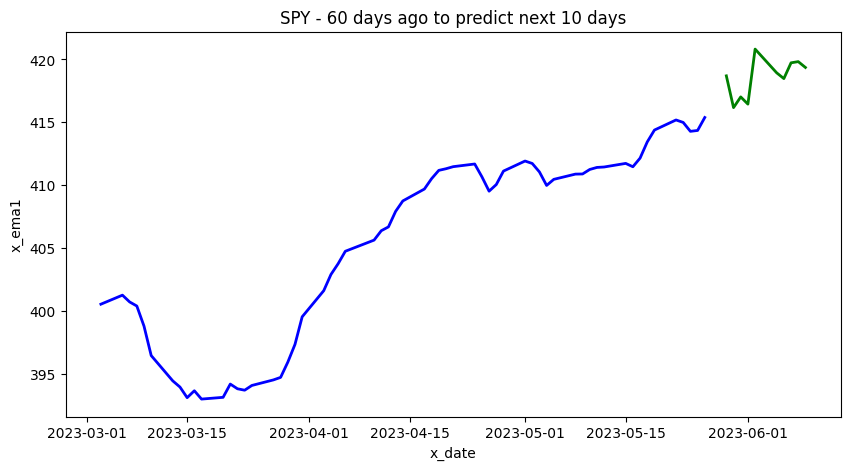

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title(f"{AssetName} - {input_sequence_length} days ago to predict next {output_sequence_length} days", fontsize=12)
#sns.lineplot(data = dfResult[prediction_col], linewidth=4.0,  markers='o',ax=ax,color='black')
sns.lineplot(data = dfInput['x_ema1'], linewidth=2.0, ax=ax,color='blue')
sns.lineplot(data = dfOutput['x_ema1'], linewidth=2.0, ax=ax,color='green')